In [1]:
#meta: 4/26/2020 Ex2.  Logistic regression.  
# Multivariate logistic regression - predict whether a student gets admitted to a university.  
# src Coursera, Standford ML course - refactor in python
# src for markup  https://github.com/dibgerge/ml-coursera-python-assignments.git
#see ex2.pdf
#Numbering per original assignments

#here 04/26/2020 Logistic Regression
#      numpy for data load (not pandas)
#      Sigmoid function: use for binary classification.
#      Vectorized implementattion of Cost function, Gradient, Predictions.
#      Interpret the modle
#      Visualise data before and after modeling, draw the Decision Boundary.


In [2]:
import numpy as np

# Plot
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import make_interp_spline, BSpline #to smooth the line between points

# Optimization module in scipy
from scipy import optimize

## 0. Warm-up

### 1.2.1 Sigmoid function


The logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function. The sigmoid function is defined as: 

$$g(z) = \frac{1}{1+e^{-z}}$$.

In [3]:
#$mathcode:  
# math.e**(x) equals to np.exp(x)
#np.exp(1) returns e which is 2.718281828459045

In [4]:
def sigmoid(z):
    """ function sigmoid
    Input  
    z - scalar, vector, or matrix shape (n+1, m)
    Output
    sigmoid function - scalar, vector or matrix
    """
    
    return  1 / (1 + np.exp(-z))


Test sigmoid function: 
 - for large positive values, the sigmoid should be close to 1   
 - for large negative values, the sigmoid should be close to 0   
 - evaluating `sigmoid(0)` should give you exactly 0.5

In [5]:
#verify sigmoid works with scalar, vector and matrix
#z = 1
z = np.array([1000,0,-1000])
#z = np.array([[1000,0,-1000],[10,0,-10]])

sigmoid(z)

array([1. , 0.5, 0. ])

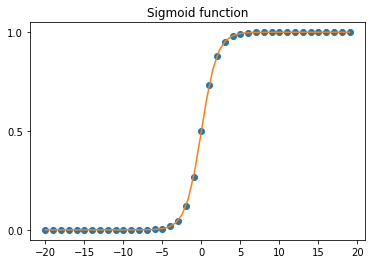

In [6]:
#visualize sigmoid function
z = np.arange(-20, 20, 1)
y = sigmoid(z)

#plot smooth sigmoid 
z_smooth = np.linspace(np.array(z).min(), np.array(z).max(), 50)
spl = make_interp_spline(np.array(z), np.array(y), k=3)  # type: BSpline
y_smooth = spl(z_smooth)

#plot
plt.title("Sigmoid function")
plt.plot(z, y, 'o')
plt.plot(z_smooth, y_smooth, '-')
plt.yticks([0,0.5,1])
plt.show()

# 1. Logistic Regression

Build a logistic regression model to predict whether a student gets admitted into a university. 

## Predict University Admissions
Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision.  

Dataset:  
*x* - scores on two exams  
*y* - admissions decision  

Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams. 

## 1.0 Load Data

Dims: m x n  => records x features

In [7]:
data = np.loadtxt('data/ex2/ex2data1.txt', delimiter=',',skiprows=0) #unpack=True
print(data.shape)

#preview data
print("Preview data")
data[0:5]


(100, 3)
Preview data


array([[34.62365962, 78.02469282,  0.        ],
       [30.28671077, 43.89499752,  0.        ],
       [35.84740877, 72.90219803,  0.        ],
       [60.18259939, 86.3085521 ,  1.        ],
       [79.03273605, 75.34437644,  1.        ]])

## 1.1 Visualizing the data
Get acquainted with the learning dataset.

In [8]:
#prep data
X=data[:,[0,1]]
y=data[:, 2]
print ("Number of data points: {}".format(y.size))

#find admitted vs not admitted
idx_admitted = np.where(y==1,True, False) #class numpy.ndarray
#X[~idx_admitted, 0]x[0, ~idx_admitted]


Number of data points: 100


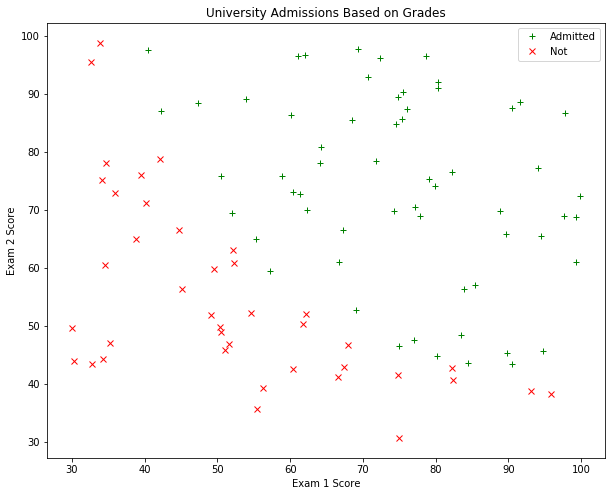

In [9]:
#plot
plt.figure(figsize=(10,8))
plt.title('University Admissions Based on Grades')

plt.plot(X[idx_admitted, 0], X[idx_admitted, 1], 'g+', label='Admitted')
plt.plot(X[~idx_admitted, 0], X[~idx_admitted, 1], 'rx', label='Not')

plt.xlabel('Exam 1 Score')
plt.ylabel ('Exam 2 Score')
plt.legend()
plt.show()

## 1.2 Implementation - Gradient Descent

Recall that the cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$
element (for $j = 0, 1, \cdots , n$) is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.
<a id="costFunction"></a>



### 1.2.2 Cost function and gradient

Implement the cost function and gradient for logistic regression.  


In [10]:
# return the cost and gradient
# note: lecture        X dims: n x m => h = g(theta.T * X) 
#       vs 
#       here reversing X dims: m x n => h = g(X * theta)

def costFunction(theta, X, y):
    """
    Compute cost and gradient for logistic regression. 
    
    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector of shape (n+1, ).
    
    X : array_like
        The input dataset of shape (m x n+1) where 
        m = total number of data points and 
        n = number of features. 
        We assume the intercept has already been added to the input.
    
    y : array_like
        Labels for the input. This is a vector of shape (m, ).
    
    Returns
    -------
    J : float
        The computed value for the cost function. 
    
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost J with respect to theta, at the current values of theta.
        
    Instructions
    ------------
    Compute J cost of a particular choice of theta.
    Compute the partial derivatives and set grad to the partial derivatives of the cost w.r.t. each param in theta.
    
    myNotes revised
    ========= 
    y_hat = X * theta => (m, n+1) x (n+1, ) x  => shape (m, )     (same as y)
    error = y_hat - y =>                          shape (m, )     (same as y)
    gradient = vector                             shape (n+1, )   (same as theta)
    X.T * (error/m) => (n+1, m) x (m, 1) =>       shape (n+1, ) 

    to multiply: use np.dot(X, theta)
    
    myNotes previously
    ========= 
    y_hat = theta.T * X => (1, n+1) x (n+1, m) => shape (1, m)     (same as y)
    error = y_hat - y   =>                        shape (1, m)     (same as y)
    gradient = vector                             shape (n+1, )    (same as theta)
    X * (error/m).T => (n+1, m) x (m, 1) =>       shape  n+1, ) 

    to multiply: use np.dot(theta.T, X)
    refer: https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html
    """
    # Initialize vars
    m = y.size  # number of training examples

    # Return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    #compute hypothesis
    #for linear regression was: y_hat = np.dot( theta.T, X )
    #for logistic regression would be: y_hat = sigmoid( np.dot(theta.T, X ))
    #reversing X dims: 
    y_hat = sigmoid( np.dot(X, theta))
     
    #compute cost  
    part1 = -y * np.log(y_hat)
    part2 = (1 - y) * np.log(1 - y_hat)
    J = (part1-part2).sum() / m
    
    #compute gradient -> hint: same dimension as theta, see myNotes
    #error = y_hat - y
    #grad = np.dot(X.T, (error/m)) 
    grad = np.dot(X.T, (y_hat - y)/m) #same dims as theta
    
    # =============================================================
    return J, grad
    

<div class="alert alert-block alert-info">
**Implementation Note:**<br>
Before proceeding we add the intercept term to X. 
</div>

In [11]:
# Setup the data matrix appropriately, and add ones for the intercept term
m, n = X.shape

print('# of features (no intercept): ', n)
print('# of records: ', m)

# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), X], axis=1)
print('X shape with intercept term: ', X.shape)
#preview X
X[:5]

# of features (no intercept):  2
# of records:  100
X shape with intercept term:  (100, 3)


array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

Compute and display initial cost and gradient. Additional check with non-zero theta.

In [12]:
# Initialize fitting parameters
initial_theta = np.zeros(n+1)
print("Theta shape: ", initial_theta.shape)
print("X shape: ", X.shape)

cost, grad = costFunction(initial_theta, X, y)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx): 0.693\n')

print('Gradient at initial theta (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Expected gradients (approx):\n\t[-0.1000, -12.0092, -11.2628]\n')

# Compute and display cost and gradient with non-zero theta
test_theta = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_theta, X, y)

print('Cost at test theta: {:.3f}'.format(cost))
print('Expected cost (approx): 0.218\n')

print('Gradient at test theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))
print('Expected gradients (approx):\n\t[0.043, 2.566, 2.647]')

Theta shape:  (3,)
X shape:  (100, 3)
Cost at initial theta (zeros): 0.693
Expected cost (approx): 0.693

Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]
Expected gradients (approx):
	[-0.1000, -12.0092, -11.2628]

Cost at test theta: 0.218
Expected cost (approx): 0.218

Gradient at test theta:
	[0.043, 2.566, 2.647]
Expected gradients (approx):
	[0.043, 2.566, 2.647]


### 1.2.3 Learning parameters using `scipy.optimize`

In the previous assignment, you found the optimal parameters of a linear regression model by implementing gradient descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy is a numerical computing library for `python`. It provides an optimization module for root finding and minimization. As of `scipy 1.0`, the function `scipy.optimize.minimize` is the method to use for optimization problems(both constrained and unconstrained).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:
- `costFunction`: A cost function that, when given the training set and a particular $\theta$, computes the logistic regression cost and gradient with respect to $\theta$ for the dataset (X, y). It is important to note that we only pass the name of the function without the parenthesis. This indicates that we are only providing a reference to this function, and not evaluating the result from this function.
- `initial_theta`: The initial values of the parameters we are trying to optimize.
- `(X, y)`: These are additional arguments to the cost function.
- `jac`: Indication if the cost function returns the Jacobian (gradient) along with cost value. (True)
- `method`: Optimization method/algorithm to use
- `options`: Additional options which might be specific to the specific optimization method. In the following, we only tell the algorithm the maximum number of iterations before it terminates.

If you have completed the `costFunction` correctly, `optimize.minimize` will converge on the right optimization parameters and return the final values of the cost and $\theta$ in a class object. Notice that by using `optimize.minimize`, you did not have to write any loops yourself, or set a learning rate like you did for gradient descent. This is all done by `optimize.minimize`: you only needed to provide a function calculating the cost and the gradient.

In the following, we already have code written to call `optimize.minimize` with the correct arguments.

In [13]:
# set options for optimize.minimize
options= {'maxiter': 400}

# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization which is 
# equivalent to MATLAB's fminunc
# See https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property
theta = res.x

# Print theta to screen
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
print('Expected cost (approx): 0.203\n');

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))
print('Expected theta (approx):\n\t[-25.161, 0.206, 0.201]')

Cost at theta found by optimize.minimize: 0.203
Expected cost (approx): 0.203

theta:
	[-25.161, 0.206, 0.201]
Expected theta (approx):
	[-25.161, 0.206, 0.201]


Once `optimize.minimize` completes, we want to use the final value for $\theta$ to visualize the decision boundary on the training data as shown in the figure below. 

![](Figures/decision_boundary1.png)

To do so, we have written a function `plotDecisionBoundary` for plotting the decision boundary on top of training data. You do not need to write any code for plotting the decision boundary, but we also encourage you to look at the code in `plotDecisionBoundary` to see how to plot such a boundary using the $\theta$ values. You can find this function in the `utils.py` file which comes with this assignment.

### 1.2.xtra Communicate Results - the Model
Hypothesis $h_\theta(x)$ is given by the logistic model

In [14]:
print("Logistic model after finding thetas: ")
print ("y_hat = {:.2f} + {:.2f} * x1 + {:.2f} * x2".format( *theta))

Logistic model after finding thetas: 
y_hat = -25.16 + 0.21 * x1 + 0.20 * x2


How to interpret the model
#### Probability of admission =  -25.16 + 0.21 x exam1 + 0.20 x exam2



### Plot Decision Boundary
Note: plot manually

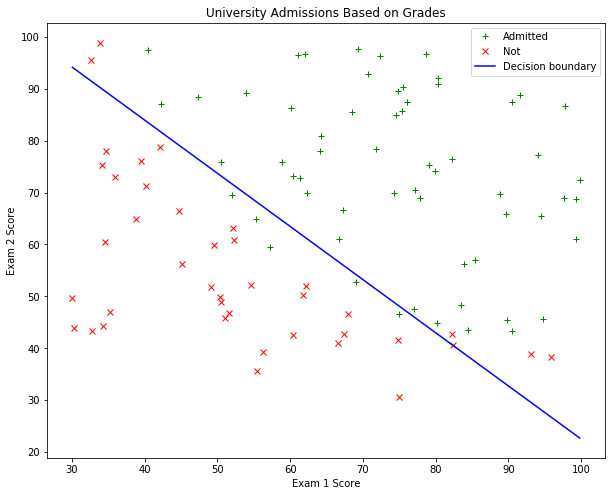

In [15]:
#plot points
plt.figure(figsize=(10,8))
plt.title('University Admissions Based on Grades')

plt.plot(X[idx_admitted, 1], X[idx_admitted, 2], 'g+', label='Admitted')
plt.plot(X[~idx_admitted, 1], X[~idx_admitted, 2], 'rx', label='Not')

#plot decision boundary
# src https://github.com/kaleko/CourseraML/blob/master/ex2/ex2.ipynb
#Plotting the decision boundary: two points, draw a line between
#Decision boundary occurs when h = 0, or when
#theta0 + theta1*x1 + theta2*x2 = 0
#y=mx+b is replaced by x2 = (-1/thetheta2)(theta0 + theta1*x1)
boundary_xs = np.array([np.min(X[:,1]), np.max(X[:,1])])
boundary_ys = (-1./theta[2])*(theta[0] + theta[1]*boundary_xs)
plt.plot(boundary_xs, boundary_ys, 'b-', label = 'Decision boundary')

plt.xlabel('Exam 1 Score')
plt.ylabel ('Exam 2 Score')
plt.legend()
plt.show()

### 1.2.4 Evaluating logistic regression

After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 45 and an Exam 2 score of 85, you should expect to see an admission
probability of 0.776. 

In [16]:
#Predict probability for a student with score 45 on exam 1 and score 85 on exam 2 
grades = np.array([1,45,85])
p=sigmoid(np.dot(grades, theta))
print("Probability of admission: ", p)
print("Prediction:", p >= 0.5)

Probability of admission:  0.7762906225323448
Prediction: True


Another way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set. In this part, your task is to complete the code in function `predict`. The predict function will produce “1” or “0” predictions given a dataset and a learned parameter vector $\theta$. 


In [17]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)
    
    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).
    
    X : array_like
        The data to use for computing predictions. 
        Rows is the number of points to compute predictions
        Columns is the number of features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 
    """
    
    # init vars
    m = X.shape[0] #Number of  examples
    p = np.zeros(m) 
    
    #compute predictions probability
    p = sigmoid(np.dot(X, theta))
    
    return p >= 0.5

In [18]:
#test with a single student
grades = np.array([[1,45,85]])
predict(theta, grades)

array([ True])

In [19]:
#test with the whole training set
y_hat = predict(theta, X);
accuracy = (y_hat == y).mean()

print('Train Accuracy: ', accuracy)
print('Expected accuracy (approx): 89.0\n');

Train Accuracy:  0.89
Expected accuracy (approx): 89.0

